In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = 'cpu'
print(device)

import neuravi

CUDA AVAILABLE?  True
cpu


# Data import

In [2]:
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5","./data/NKAS_Raman.hdf5","./data/NKAS_density.hdf5",device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Architecture experiment results

In [8]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)
record_loss["loss_ag_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)
record_loss["loss_Sconf_test"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)
record_loss["loss_d_test"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    
    # train
    y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
    y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
    y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
    y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
    y_density_pred_train = neuralmodel.density(ds.x_density_train)
    y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)

    # valid
    y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
    y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
    y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
    y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
    y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
    y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
    
    # test
    y_ag_pred_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)
    y_myega_pred_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)
    y_am_pred_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)
    #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
    y_density_pred_test = neuralmodel.density(ds.x_density_test)
    y_entro_pred_test = neuralmodel.sctg(ds.x_entro_test)

    # Compute Loss

    # train 
    record_loss.loc[idx,"loss_ag_train"] = criterion(y_ag_pred_train, ds.y_visco_train).item()
    record_loss.loc[idx,"loss_myega_train"]  = criterion(y_myega_pred_train, ds.y_visco_train).item()
    record_loss.loc[idx,"loss_am_train"]  = criterion(y_am_pred_train, ds.y_visco_train).item()
    record_loss.loc[idx,"loss_raman_train"]  = criterion(y_raman_pred_train,ds.y_raman_train).item()
    record_loss.loc[idx,"loss_d_train"]  = criterion(y_density_pred_train,ds.y_density_train).item()
    record_loss.loc[idx,"loss_Sconf_train"]  = criterion(y_entro_pred_train,ds.y_entro_train).item()

    # validation
    record_loss.loc[idx,"loss_ag_valid"] = criterion(y_ag_pred_valid, ds.y_visco_valid).item()
    record_loss.loc[idx,"loss_myega_valid"] = criterion(y_myega_pred_valid, ds.y_visco_valid).item()
    record_loss.loc[idx,"loss_am_valid"] = criterion(y_am_pred_valid, ds.y_visco_valid).item()
    record_loss.loc[idx,"loss_raman_valid"] = criterion(y_raman_pred_valid,ds.y_raman_valid).item()
    record_loss.loc[idx,"loss_d_valid"] = criterion(y_density_pred_valid,ds.y_density_valid).item()
    record_loss.loc[idx,"loss_Sconf_valid"] = criterion(y_entro_pred_valid,ds.y_entro_valid).item()
    
    # test
    record_loss.loc[idx,"loss_ag_test"] = criterion(y_ag_pred_test, ds.y_visco_test).item()
    record_loss.loc[idx,"loss_myega_test"] = criterion(y_myega_pred_test, ds.y_visco_test).item()
    record_loss.loc[idx,"loss_am_test"] = criterion(y_am_pred_test, ds.y_visco_test).item()
    #record_loss.loc[idx,"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item()
    record_loss.loc[idx,"loss_d_test"] = criterion(y_density_pred_test,ds.y_density_test).item()
    record_loss.loc[idx,"loss_Sconf_test"] = criterion(y_entro_pred_test,ds.y_entro_test).item()



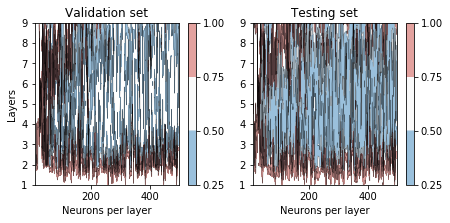

In [9]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# for drawing levels
lv_ = [0.25,0.5,0.75,1.0]

# Data to plot
x = record_loss.loc[:,"nb_neurons"]
y = record_loss.loc[:,"nb_layers"]
z = record_loss.loc[:,"loss_ag_valid"]
z2 = record_loss.loc[:,"loss_ag_test"]

# Figure
fig = plt.figure(figsize=(6.4,3.2))

# Valid
ax = plt.subplot(1,2,1)
ax.tricontour(x, y, z, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr = ax.tricontourf(x, y, z, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

# Test
ax2 = plt.subplot(1,2,2)
ax2.tricontour(x, y, z2, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr2 = ax2.tricontourf(x, y, z2, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax2)

# Where are the points made?
#ax.plot(x,y,"k.")
#ax2.plot(x,y,"k.")

# Labels
ax.set_xlabel("Neurons per layer")
ax2.set_xlabel("Neurons per layer")
ax.set_ylabel("Layers")

# Titles
ax.set_title('Validation set')
ax2.set_title('Testing set')

plt.tight_layout()

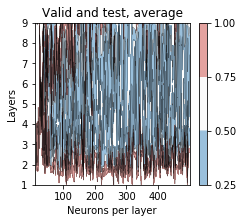

In [10]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# for drawing levels
lv_ = [0.25,0.5,0.75,1.0]

# Data to plot
x = record_loss.loc[:,"nb_neurons"]
y = record_loss.loc[:,"nb_layers"]
z = (record_loss.loc[:,"loss_ag_valid"]+record_loss.loc[:,"loss_ag_test"])/2

# Figure
fig = plt.figure(figsize=(6.4,3.2))

# Valid
ax = plt.subplot(1,2,1)
ax.tricontour(x, y, z, levels=lv_, linewidths=0.5, alpha=0.5,colors='k')
cntr = ax.tricontourf(x, y, z, levels=lv_, alpha=0.5,cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

# Labels
ax.set_xlabel("Neurons per layer")
ax.set_ylabel("Layers")

# Titles
ax.set_title('Valid and test, average')

plt.tight_layout()

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


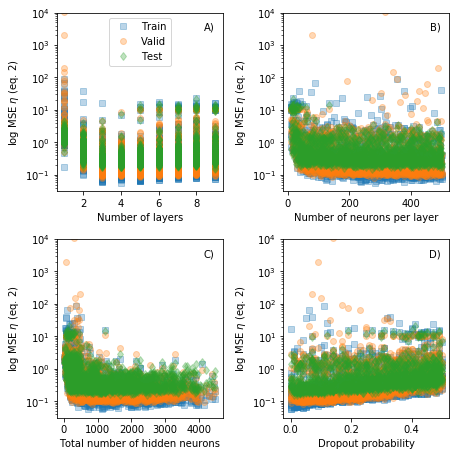

In [11]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)
plt.plot(record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.3,color="C0",label="Train")
plt.plot(record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.3,color="C1",label="Valid")
plt.plot(record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.3,color="C2",label="Test")
plt.yscale('log')

plt.ylim(-2,10000)

plt.xlabel("Number of layers")
plt.ylabel("log MSE $\eta$ (eq. 2)")
plt.legend(loc="upper center")
plt.annotate("A)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(2,2,2)
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.3,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.3,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.3,color="C2")
plt.yscale('log')

plt.ylim(-2,10000)

plt.xlabel("Number of neurons per layer")
plt.ylabel("log MSE $\eta$ (eq. 2)")
           
plt.annotate("B)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(2,2,3)
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.3,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.3,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.3,color="C2")
plt.yscale('log')

plt.ylim(-2,10000)

plt.xlabel("Total number of hidden neurons")
plt.ylabel("log MSE $\eta$ (eq. 2)")
           
plt.annotate("C)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(2,2,4)
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_train"],"s",color="C0",alpha=0.3,label="Train")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_valid"],"o",color="C1",alpha=0.3,label="Valid")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_test"],"d",color="C2",alpha=0.3,label="Test")
plt.yscale('log')

plt.ylim(-2,10000)

plt.annotate("D)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.xlabel("Dropout probability")
plt.ylabel("log MSE $\eta$ (eq. 2)")

plt.tight_layout()
plt.savefig("./figures/Figure_MSE.pdf")

In [12]:
# Detect best model
np.array(list_models)[record_loss.loc[:,"loss_ag_test"].values == record_loss.loc[:,"loss_ag_test"].values.min()]

array(['l9_n272_p0.02.pth'], dtype='<U17')

In [32]:
list_models

['l1_n286_p0.0.pth',
 'l7_n117_p0.45.pth',
 'l7_n242_p0.28.pth',
 'l5_n41_p0.46.pth',
 'l2_n234_p0.11.pth',
 'l2_n399_p0.18.pth',
 'l9_n365_p0.46.pth',
 'l4_n128_p0.41.pth',
 'l1_n62_p0.2.pth',
 'l8_n68_p0.14.pth',
 'l2_n368_p0.33.pth',
 'l9_n272_p0.35.pth',
 'l9_n351_p0.31.pth',
 'l4_n329_p0.16.pth',
 'l8_n86_p0.07.pth',
 'l3_n15_p0.18.pth',
 'l3_n43_p0.26.pth',
 'l9_n143_p0.01.pth',
 'l1_n62_p0.06.pth',
 'l6_n161_p0.36.pth',
 'l2_n51_p0.39.pth',
 'l4_n380_p0.5.pth',
 'l5_n111_p0.33.pth',
 'l1_n343_p0.5.pth',
 'l8_n63_p0.07.pth',
 'l5_n153_p0.25.pth',
 'l3_n353_p0.17.pth',
 'l3_n207_p0.4.pth',
 'l8_n37_p0.46.pth',
 'l9_n123_p0.36.pth',
 'l7_n369_p0.23.pth',
 'l5_n157_p0.48.pth',
 'l9_n309_p0.13.pth',
 'l6_n282_p0.41.pth',
 'l5_n106_p0.06.pth',
 'l2_n248_p0.28.pth',
 'l4_n62_p0.34.pth',
 'l7_n398_p0.08.pth',
 'l7_n307_p0.36.pth',
 'l6_n115_p0.14.pth',
 'l7_n190_p0.31.pth',
 'l8_n41_p0.27.pth',
 'l6_n40_p0.4.pth',
 'l7_n13_p0.21.pth',
 'l4_n365_p0.08.pth',
 'l5_n216_p0.21.pth',
 'l1_n25